In [16]:
from time import time

from oemof import solph
import tsam.timeseriesaggregation as tsam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def preprocessing(noTypicalPeriods, hoursPerPeriod, data):
    aggregation = tsam.TimeSeriesAggregation(
        data,
        noTypicalPeriods=noTypicalPeriods,
        hoursPerPeriod=hoursPerPeriod,
        clusterMethod='k_means'
    )

    agg_data = aggregation.createTypicalPeriods()

    agg_data.index.names = ['TypicalPeriod', 'TimeStep']
    agg_data.reset_index(inplace=True)

    return aggregation, agg_data

In [18]:
def optimization(agg_data):
    timeindex = pd.date_range('2024-01-01 00:00', freq='h', periods=agg_data.shape[0])
    es = solph.EnergySystem(
        timeindex=timeindex, infer_last_interval=True
    )

    b_gas = solph.Bus("gas bus")
    b_electricity = solph.Bus("electricity bus")
    b_heat = solph.Bus("heat bus")

    source_gas = solph.components.Source(
        "gas source",
        outputs={b_gas: solph.Flow(variable_costs=agg_data["gas_price"] + agg_data["co2_price"])}
    )
    source_electricity = solph.components.Source(
        "electricity source",
        outputs={b_electricity: solph.Flow(variable_costs=agg_data["el_spot_price"])}
    )
    sink_heat = solph.components.Sink(
        "heat demand",
        inputs={b_heat: solph.Flow(fix=agg_data["heat"], nominal_value=1)}
    )

    heat_pump = solph.components.Converter(
        label="heat pump",
        inputs={b_electricity: solph.Flow()},
        outputs={b_heat: solph.Flow(nominal_value=100)},
        conversion_factors={b_heat: 3.5}
    )
    boiler = solph.components.Converter(
        label="gas boiler",
        inputs={b_gas: solph.Flow()},
        outputs={b_heat: solph.Flow(nominal_value=100)},
        conversion_factors={b_heat: 0.9}
    )

    heat_slack = solph.components.Source(
        label="heat slack",
        outputs={b_heat: solph.Flow(variable_costs=1000)}
    )

    storage = solph.components.GenericStorage(
        label="heat storage",
        inputs={b_heat: solph.Flow(nominal_value=50)},
        outputs={b_heat: solph.Flow(nominal_value=50)},
        nominal_storage_capacity=24 * 50,
        initial_storage_level=0.5,
        balanced=True
    )

    es.add(
        b_gas, b_electricity, b_heat,
        source_electricity, source_gas, sink_heat, heat_slack,
        heat_pump, boiler, storage
    )

    model = solph.Model(es)

    _ = model.solve("gurobi")

    results = solph.views.convert_keys_to_strings(model.results())

    return results

In [19]:
def postprocessing(results, agg_data, aggregation):
    unitdata = pd.DataFrame()
    for vertex, data in results.items():
        if vertex[-1] != 'None':
            unitdata[' to '.join(vertex)] = data['sequences']['flow']
        else:
            unitdata[f'{vertex[0]} storage content'] = data['sequences']['storage_content']

    unitdata.dropna(inplace=True)
    unitdata.reset_index(inplace=True, drop=True)

    unitdata = pd.concat([unitdata, agg_data[['TypicalPeriod', 'TimeStep']]], axis=1)
    unitdata.set_index(['TypicalPeriod', 'TimeStep'], inplace=True)

    matched_indices = aggregation.indexMatching()

    periods = unitdata.index.get_level_values('TypicalPeriod')
    timesteps = unitdata.index.get_level_values('TimeStep')

    unitdata_flat = pd.DataFrame(unitdata.values, columns=unitdata.columns)
    unitdata_flat['PeriodNum'] = periods
    unitdata_flat['TimeStep'] = timesteps

    desagg_data = matched_indices.reset_index().merge(
        unitdata_flat,
        how='left',
        left_on=['PeriodNum', 'TimeStep'],
        right_on=['PeriodNum', 'TimeStep']
    ).set_index(matched_indices.index)

    desagg_data = desagg_data.drop(columns=['Date', 'PeriodNum', 'TimeStep'])

    return desagg_data

In [39]:
def calc_key_params(desagg_data, ts_in):
    el_cost = (desagg_data['electricity source to electricity bus'] * ts_in['el_spot_price']).sum()
    gas_cost = (desagg_data['gas source to gas bus'] * (
        ts_in['gas_price'] + ts_in['co2_price']
    )).sum()
    slack_cost = (desagg_data['heat slack to heat bus'] * 1000).sum()

    opex_total = el_cost + gas_cost + slack_cost

    heat_prod_shares = (
        desagg_data[['heat pump to heat bus', 'gas boiler to heat bus', 'heat slack to heat bus']].sum()
        / desagg_data[['heat pump to heat bus', 'gas boiler to heat bus', 'heat slack to heat bus']].sum().sum()
        )
    heat_prod_shares

    return opex_total, heat_prod_shares

In [21]:
def test_agg_performance(noTypicalPeriods, hoursPerPeriod):
    ts_in = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)
    ts_in = ts_in.drop(columns="ef_om")
    missing_hours = ts_in.shape[0] % hoursPerPeriod
    if missing_hours > 0:
        ts_in = ts_in.iloc[:-missing_hours, :]

    print('Perfomance Clustering & Preprocessing:')
    %timeit aggregation, agg_data = preprocessing(noTypicalPeriods=noTypicalPeriods, hoursPerPeriod=hoursPerPeriod, data=ts_in)
    print('Perfomance Optimization:')
    %timeit results = optimization(agg_data=agg_data)
    print('Perfomance Desaggregation:')
    %timeit desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)

In [22]:
def run_optimization_timed(noTypicalPeriods, hoursPerPeriod):
    ts_in = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)
    ts_in = ts_in.drop(columns="ef_om")
    missing_hours = ts_in.shape[0] % hoursPerPeriod
    if missing_hours > 0:
        ts_in = ts_in.iloc[:-missing_hours, :]

    starttime = time()
    aggregation, agg_data = preprocessing(noTypicalPeriods=noTypicalPeriods, hoursPerPeriod=hoursPerPeriod, data=ts_in)
    aggregation_time = time() - starttime

    starttime = time()
    results = optimization(agg_data=agg_data)
    optimization_time = time() - starttime

    starttime = time()
    desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)
    disaggregation_time = time() - starttime

    opex_total, heat_prod_shares = calc_key_params(desagg_data=desagg_data, ts_in=ts_in)

    return aggregation_time, optimization_time, disaggregation_time, desagg_data, opex_total, heat_prod_shares

In [23]:
noTypicalPeriods = 10
hoursPerPeriod = 168

ts_in = pd.read_csv("time_series.csv", index_col=0, parse_dates=True)
ts_in = ts_in.drop(columns="ef_om")
missing_hours = ts_in.shape[0] % hoursPerPeriod
if missing_hours > 0:
    ts_in = ts_in.iloc[:-missing_hours, :]
ts_in.shape

(8736, 4)

In [24]:
aggregation, agg_data = preprocessing(noTypicalPeriods=noTypicalPeriods, hoursPerPeriod=hoursPerPeriod, data=ts_in)

In [25]:
agg_data

,TypicalPeriod,TimeStep,co2_price,el_spot_price,gas_price,heat
0,0,0,21.624,30.066,19.3396,174.780000
1,0,1,21.624,28.572,19.3396,179.610000
2,0,2,21.624,27.264,19.3396,182.242000
3,0,3,21.624,27.088,19.3396,186.886000
4,0,4,21.624,26.782,19.3396,201.654000
...,...,...,...,...,...,...
1675,9,163,25.526,49.932,13.3738,54.199881
1676,9,164,25.526,44.468,13.3738,56.629515
1677,9,165,25.526,40.606,13.3738,56.961312
1678,9,166,25.526,35.306,13.3738,57.489545


In [26]:
results = optimization(agg_data=agg_data)
results

{('electricity bus',
  'heat pump'): {'scalars': Series([], Name: 2024-01-01 00:00:00, dtype: float64), 'sequences': variable_name             flow
  2024-01-01 00:00:00  28.571429
  2024-01-01 01:00:00  28.571429
  2024-01-01 02:00:00  28.571429
  2024-01-01 03:00:00  28.571429
  2024-01-01 04:00:00  28.571429
  ...                        ...
  2024-03-10 20:00:00   1.894147
  2024-03-10 21:00:00   1.988946
  2024-03-10 22:00:00   2.139870
  2024-03-10 23:00:00  28.571429
  2024-03-11 00:00:00        NaN
  
  [1681 rows x 1 columns]},
 ('electricity source',
  'electricity bus'): {'scalars': Series([], Name: 2024-01-01 00:00:00, dtype: float64), 'sequences': variable_name             flow
  2024-01-01 00:00:00  28.571429
  2024-01-01 01:00:00  28.571429
  2024-01-01 02:00:00  28.571429
  2024-01-01 03:00:00  28.571429
  2024-01-01 04:00:00  28.571429
  ...                        ...
  2024-03-10 20:00:00   1.894147
  2024-03-10 21:00:00   1.988946
  2024-03-10 22:00:00   2.139870
  20

In [27]:
# desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)
desagg_data = postprocessing(results=results, agg_data=agg_data, aggregation=aggregation)
desagg_data

,electricity bus to heat pump,electricity source to electricity bus,gas boiler to heat bus,gas bus to gas boiler,gas source to gas bus,heat bus to heat demand,heat bus to heat storage,heat pump to heat bus,heat slack to heat bus,heat storage storage content,heat storage to heat bus
Date,,,,,,,,,,,
2019-01-01 00:00:00,28.571429,28.571429,62.2350,69.150000,69.150000,179.8925,32.3425,100.0,0.000,1200.0000,50.0000
2019-01-01 01:00:00,28.571429,28.571429,100.0000,111.111111,111.111111,182.3425,50.0000,100.0,0.000,1182.3425,32.3425
2019-01-01 02:00:00,28.571429,28.571429,89.9100,99.900000,99.900000,189.9100,0.0000,100.0,0.000,1200.0000,0.0000
2019-01-01 03:00:00,28.571429,28.571429,99.4075,110.452778,110.452778,199.4075,0.0000,100.0,0.000,1200.0000,0.0000
2019-01-01 04:00:00,28.571429,28.571429,100.0000,111.111111,111.111111,212.0450,0.0000,100.0,12.045,1200.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,28.571429,28.571429,99.2650,110.294444,110.294444,199.2650,0.0000,100.0,0.000,0.0000,0.0000
2019-12-30 20:00:00,28.571429,28.571429,86.8980,96.553333,96.553333,186.8980,0.0000,100.0,0.000,0.0000,0.0000
2019-12-30 21:00:00,28.571429,28.571429,74.5730,82.858889,82.858889,174.5730,0.0000,100.0,0.000,0.0000,0.0000


Text(0, 0.5, 'Stündliche Wärmeproduktion in MW')

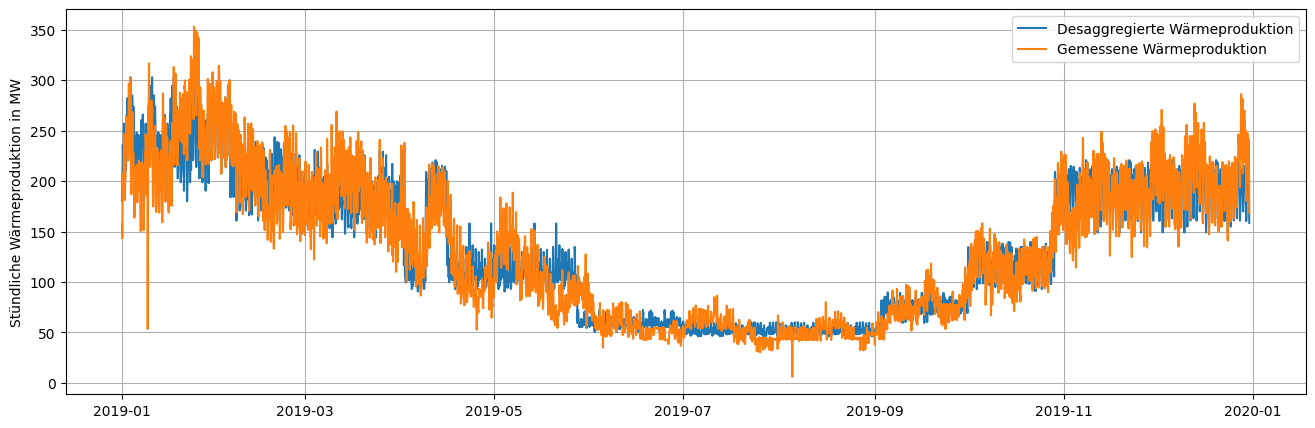

In [28]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(desagg_data['heat bus to heat demand'], label='Desaggregierte Wärmeproduktion')
ax.plot(ts_in['heat'], label='Gemessene Wärmeproduktion')

ax.legend()
ax.grid()
ax.set_ylabel('Stündliche Wärmeproduktion in MW')

Text(0, 0.5, 'Wärmespeicherfüllstand in MWh')

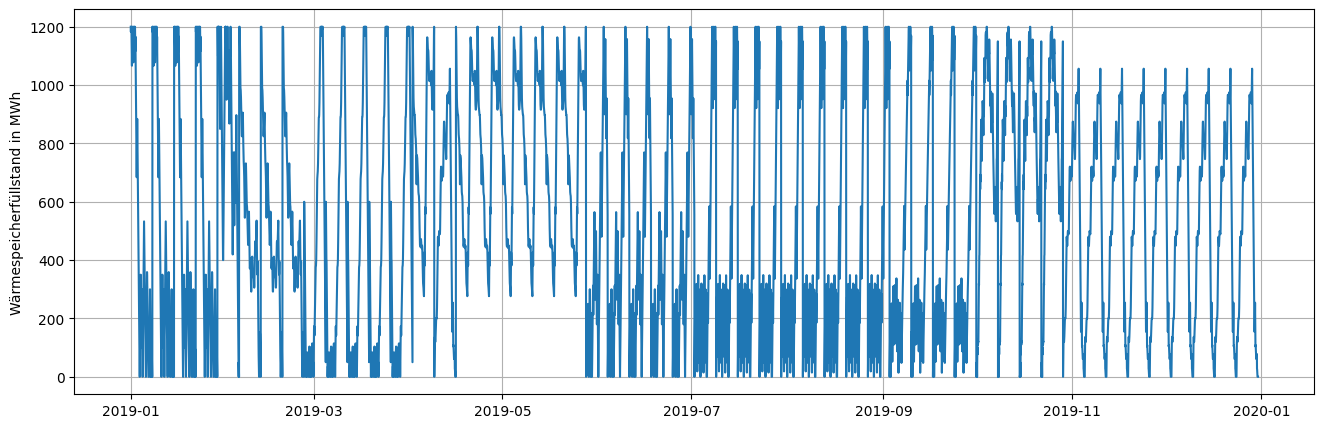

In [29]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(desagg_data['heat storage storage content'])

ax.grid()
ax.set_ylabel('Wärmespeicherfüllstand in MWh')

In [30]:
test_agg_performance(noTypicalPeriods=10, hoursPerPeriod=168)

Perfomance Clustering & Preprocessing:
1.13 s ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Perfomance Optimization:
1.59 s ± 63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Perfomance Desaggregation:
134 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
nr_periods = list(range(1, 21))
hours_per_period = [24, 3*24, 7*24, 14*24]

multiindex = pd.MultiIndex.from_product([nr_periods, hours_per_period])
perf = pd.DataFrame(index=multiindex)

for nr_period in nr_periods:
    for hour_pp in hours_per_period:
        aggregation_time, optimization_time, disaggregation_time, desagg_data, opex_total, heat_prod_shares = run_optimization_timed(noTypicalPeriods=nr_period, hoursPerPeriod=hour_pp)
        perf.loc[(nr_period, hour_pp), 'aggregation_time'] = aggregation_time
        perf.loc[(nr_period, hour_pp), 'optimization_time'] = optimization_time
        perf.loc[(nr_period, hour_pp), 'disaggregation_time'] = disaggregation_time
        perf.loc[(nr_period, hour_pp), 'opex_total'] = opex_total

perf['total_time'] = perf['aggregation_time'] + perf['optimization_time'] + perf['disaggregation_time']

22761582.708093207
22480517.086455517
22623096.059432037
22618249.44702174
28134546.55956275
30885205.392589003
38861829.38488517
48629729.136901766
24511722.363077432
32482336.210227598
41085099.7860318
47718051.83811938
25517770.840386316
31720531.700105857
33928703.03975586
51215306.090159
38129888.59268345
51546345.138825834
57655375.48492681
51909140.105083585
36506822.0462568
45361928.28550159
55020651.34236489
52032950.70647138
30624530.795459956
42944687.982418895
58101975.17787239
53398434.74223365
28268459.083279446
41619484.525648125
54853604.67489803
57909725.39240138
27044402.942678053
41826133.65239455
55079587.670277424
60886156.56034199
28164462.071635783
41858389.15569883
58598406.0421125
58940351.78335244
35320806.44027368
46544850.032402456
58782126.84374614
58907966.45600033
30919837.695848167
48046484.53504677
56097619.99282961
58928159.32179926
30990500.738014817
59373557.48841235
55970790.461054295
62117637.60732646
36187266.154714756
49038552.4623426


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['co2_price', 'el_spot_price']
  warnings.warn(


56388022.67014289


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['co2_price', 'el_spot_price']
  warnings.warn(


62421072.61476488
32540319.834869657
52315506.75363234


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(


57070237.3364688


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['co2_price', 'el_spot_price']
  warnings.warn(


64484943.581996016
35871290.36721432
52572737.62542923
57778991.88479115


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['co2_price', 'el_spot_price']
  warnings.warn(


63201707.180031806
39791865.31731871
54923744.96305733


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(


58215600.85249115


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(


63636679.34700972
35040519.571644664
51254509.091086745


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(


55872767.34212592


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(


62457919.062947884
34247363.494580194
56408189.07688299


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(


55960208.46972492


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(


64603386.34938641
36975686.21222031
54923116.59968267


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(


59663160.212103836


c:\Users\jfrei\.conda\envs\tsam_solph_py311\Lib\site-packages\tsam\timeseriesaggregation.py:1099: UserWarning: Something went wrong... At least one maximal value of the aggregated time series exceeds the maximal value the input time series for: ['el_spot_price']
  warnings.warn(


67694579.90963164


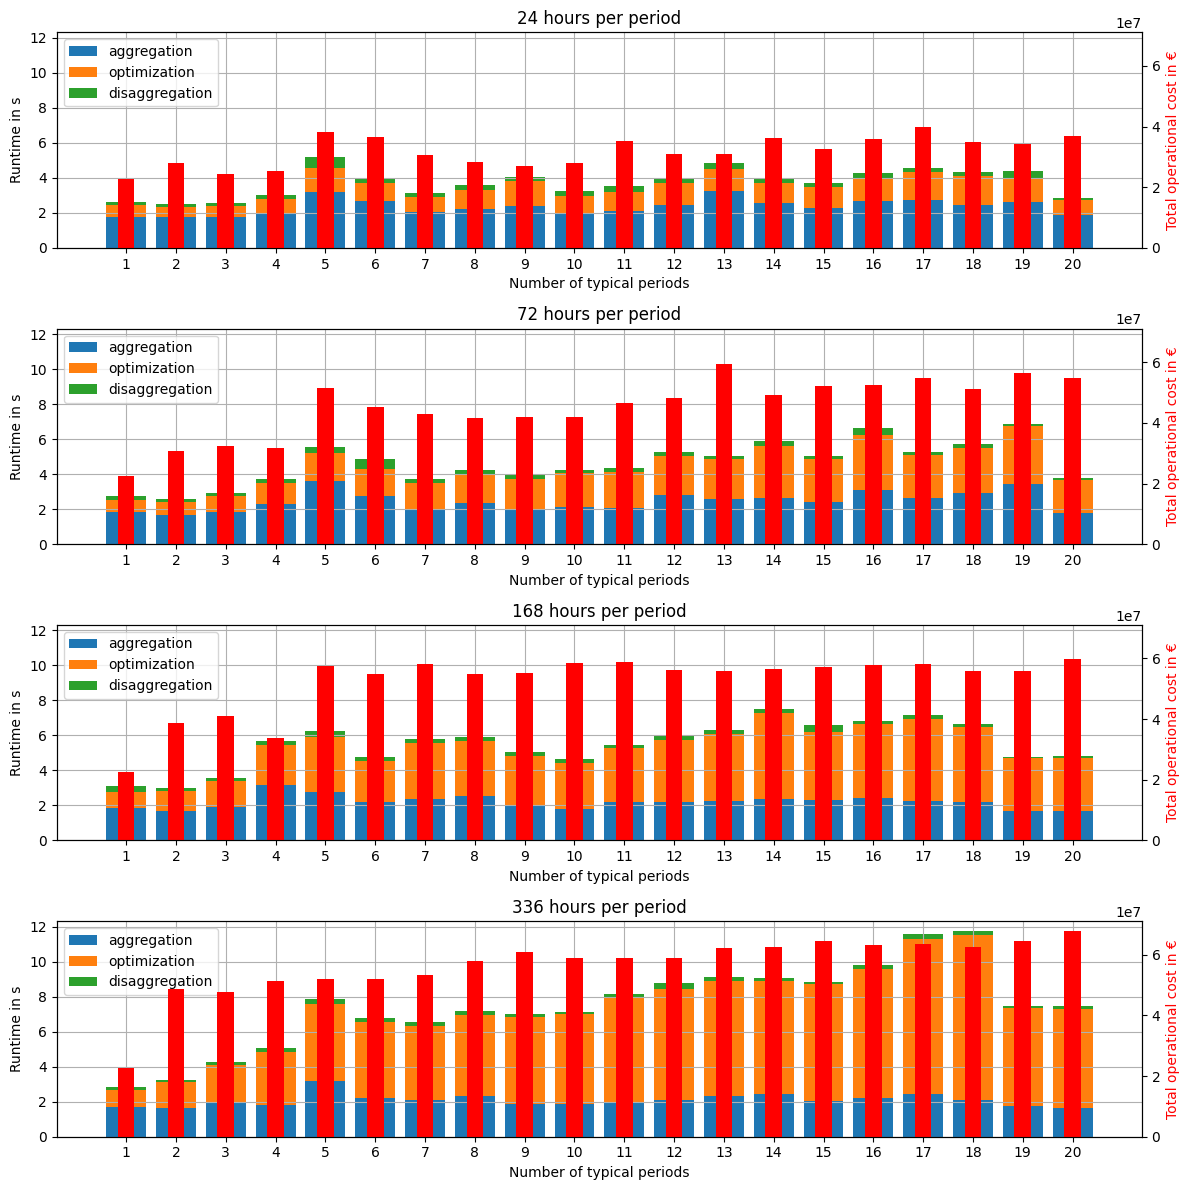

In [47]:
nr_axs = len(hours_per_period)
fig, ax = plt.subplots(nr_axs, 1, figsize=(12, 3*nr_axs))

for i, hour_pp in enumerate(hours_per_period):
    ax[i].bar(nr_periods, perf.loc[(nr_periods, hour_pp), 'aggregation_time'], label='aggregation')
    ax[i].bar(nr_periods, perf.loc[(nr_periods, hour_pp), 'optimization_time'], label='optimization', bottom=perf.loc[(nr_periods, hour_pp), 'aggregation_time'])
    ax[i].bar(nr_periods, perf.loc[(nr_periods, hour_pp), 'disaggregation_time'], label='disaggregation', bottom=perf.loc[(nr_periods, hour_pp), 'aggregation_time']+perf.loc[(nr_periods, hour_pp), 'optimization_time'])
    
    ax2 = ax[i].twinx()
    ax2.bar(nr_periods, perf.loc[(nr_periods, hour_pp), 'opex_total'], width=1/3, label='opex_total', color='red')
    ax2.set_ylim(0, 1.05*perf['opex_total'].max())
    ax2.set_ylabel('Total operational cost in €', color='red')

    ax[i].grid()
    ax[i].set_ylim(0, 1.05*perf['total_time'].max())
    ax[i].set_xticks(nr_periods, labels=nr_periods)
    ax[i].set_title(f'{hour_pp} hours per period')
    ax[i].set_xlabel('Number of typical periods')
    ax[i].set_ylabel('Runtime in s')
    ax[i].legend(loc='upper left')

plt.tight_layout()